In [26]:
from feed_forward_network import FeedForwardNetwork
from lstm import LSTM
from transformer import Transformer

from preprocessing import *
from utils import *
from features import *

In [ ]:
import pandas as pd

from sklearn.preprocessing import StandardScaler

In [27]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    torch.mps.set_per_process_memory_fraction(0.)
else:
    device = torch.device("cpu")
device

device(type='mps')

In [28]:
raw_data = pd.read_csv('consumption_and_temperatures.csv')
raw_data['timestamp'] = pd.to_datetime(raw_data['timestamp'])

In [29]:
seq_len = 0
scale_output=True
target_column = 'NO1_consumption'

In [30]:
features_to_add_ffn = [
    (   
        pick_location_data,
        { 'loc': [1] }
    ),
    (
        add_season_columns, 
        {}
    ),
    (
        shift_data, 
        {
            "shift_max": 10,
            "column_to_shift": "NO1_temperature",
            "new_column_name": "temp"
        }
    ),
    (
        shift_data, 
        {   
            "shift_min": 24,
            "shift_max": 24,
            "column_to_shift": "NO1_consumption",
            "new_column_name": "consum"
        },
    ),
    (
        add_hour_columns,
        {}
    ),
    (
        get_yesterday_target_mean,
        {'target': 'NO1_consumption'}
    )
]

In [31]:
scaler1 = StandardScaler()
scaler2 = StandardScaler()
scaler3 = StandardScaler()

In [32]:
_, _, (X_test, y_test), (_, scalerOutputMethod1), _ = general_preprocessing(
        raw_data, 
        features_to_add=features_to_add_ffn,
        seq_len=seq_len,
        scale_output=scale_output,
        scalerInputMethod=scaler1
    )

FEATURES:
 Index(['NO1_temperature', 'season_fall', 'season_spring', 'season_summer',
       'season_winter', 'temp_1_previous', 'temp_2_previous',
       'temp_3_previous', 'temp_4_previous', 'temp_5_previous',
       'temp_6_previous', 'temp_7_previous', 'temp_8_previous',
       'temp_9_previous', 'temp_10_previous', 'consum_24_previous', 'hour_0',
       'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7',
       'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13',
       'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19',
       'hour_20', 'hour_21', 'hour_22', 'hour_23',
       'NO1_consumption_yesterday_mean'],
      dtype='object')


/Users/arthurtestard/ntnu_code/deep_learning/project_2/preprocessing.py:158: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[features_to_scale] = scalerInputMethod.fit_transform(X_train[features_to_scale].values) if not is_scaler_fitted else  scalerInputMethod.transform(X_train[features_to_scale].values)
/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/arthurtestard/ntnu_code/deep_learning/project_2/preprocessing.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

In [33]:
path1 = "FeedForwardNet-2024-03-19-loss-0.041835472"
path1 = "models/" + path1

In [34]:
model1 = FeedForwardNetwork(input_size=X_test.shape[1])
model1.load_state_dict(torch.load(path1))
model1.to(device)

FeedForwardNetwork(
  (net): Sequential(
    (0): Linear(in_features=41, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=4, bias=True)
    (3): Linear(in_features=4, out_features=1, bias=True)
  )
)

In [35]:
y_test1, y_pred1 = predict(model1, scalerOutputMethod1, (X_test, y_test))

In [36]:
seq_len = 72

features_to_add_lstm = [
    (   
        pick_location_data,
        { 'loc': [1] }
    ),
    (
        add_season_columns, 
        {}
    ),
    (
        shift_data, 
        {   
            "shift_min": 24,
            "shift_max": 24,
            "column_to_shift": "NO1_consumption",
            "new_column_name": "consum"
        },
    ),
    (
        add_hour_columns,
        {}
    )
]

In [39]:
_, _, (X_test, y_test), (_, scalerOutputMethod2), _ = general_preprocessing(
        raw_data, 
        features_to_add=features_to_add_lstm,
        seq_len=seq_len,
        scale_output=scale_output,
        scalerInputMethod=scaler2
    )

FEATURES:
 Index(['NO1_temperature', 'season_fall', 'season_spring', 'season_summer',
       'season_winter', 'consum_24_previous', 'hour_0', 'hour_1', 'hour_2',
       'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9',
       'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15',
       'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21',
       'hour_22', 'hour_23'],
      dtype='object')


/Users/arthurtestard/ntnu_code/deep_learning/project_2/preprocessing.py:158: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[features_to_scale] = scalerInputMethod.fit_transform(X_train[features_to_scale].values) if not is_scaler_fitted else  scalerInputMethod.transform(X_train[features_to_scale].values)
/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/arthurtestard/ntnu_code/deep_learning/project_2/preprocessing.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

In [40]:
path2 = "LSTM-no-prev-y-2024-03-19-loss-0.07680506"
path2 = "models/" + path2

In [41]:
input_size = X_test.shape[2]
hidden_size = 11
num_layers = 3

model2 = LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, device=device)
model2.load_state_dict(torch.load(path2))
model2.to(device)

LSTM(
  (lstm): LSTM(30, 11, num_layers=3, batch_first=True)
  (linear): Linear(in_features=11, out_features=1, bias=True)
)

In [42]:
y_test2, y_pred2 = predict(model2, scalerOutputMethod2, (X_test, y_test))

In [43]:
seq_len = 48
features_to_add_transformer = [
    (   
        pick_location_data,
        { 'loc': [1] }
    ),
    (
        add_season_columns, 
        {}
    ),
    (
        shift_data, 
        {   
            "shift_min": 24,
            "shift_max": 24,
            "column_to_shift": "NO1_consumption",
            "new_column_name": "consum"
        },
    ),
    (
        add_hour_columns,
        {}
    )
]

In [44]:
_, _, (X_test, y_test), (_, scalerOutputMethod3), _ = general_preprocessing(
        raw_data, 
        features_to_add=features_to_add_transformer,
        seq_len=seq_len,
        scale_output=scale_output,
        scalerInputMethod=scaler3,
    )

FEATURES:
 Index(['NO1_temperature', 'season_fall', 'season_spring', 'season_summer',
       'season_winter', 'consum_24_previous', 'hour_0', 'hour_1', 'hour_2',
       'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9',
       'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15',
       'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21',
       'hour_22', 'hour_23'],
      dtype='object')


/Users/arthurtestard/ntnu_code/deep_learning/project_2/preprocessing.py:158: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[features_to_scale] = scalerInputMethod.fit_transform(X_train[features_to_scale].values) if not is_scaler_fitted else  scalerInputMethod.transform(X_train[features_to_scale].values)
/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/arthurtestard/ntnu_code/deep_learning/project_2/preprocessing.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

In [45]:
path3 = "Transformer-2024-03-20-loss-0.035382744"
path3 = "models/" + path3

model3 = Transformer(input_size=X_test.shape[2])
model3.load_state_dict(torch.load(path3))
model3.to(device)

Transformer(
  (embedding): Linear(in_features=30, out_features=64, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (linear): Linear(in_features=64, out_features=1, bias=True)
)

In [46]:
y_test3, y_pred3 = predict(model3, scalerOutputMethod3, (X_test, y_test))

In [47]:
preds = {
    'ffn': torch.Tensor(y_pred1),
    'lstm': torch.Tensor(y_pred2),
    'transformer': torch.Tensor(y_pred3)
}

targets = {
    'ffn': torch.Tensor(y_test1),
    'lstm': torch.Tensor(y_test2),
    'transformer': torch.Tensor(y_test3)
}

3 3
3 3
3 3


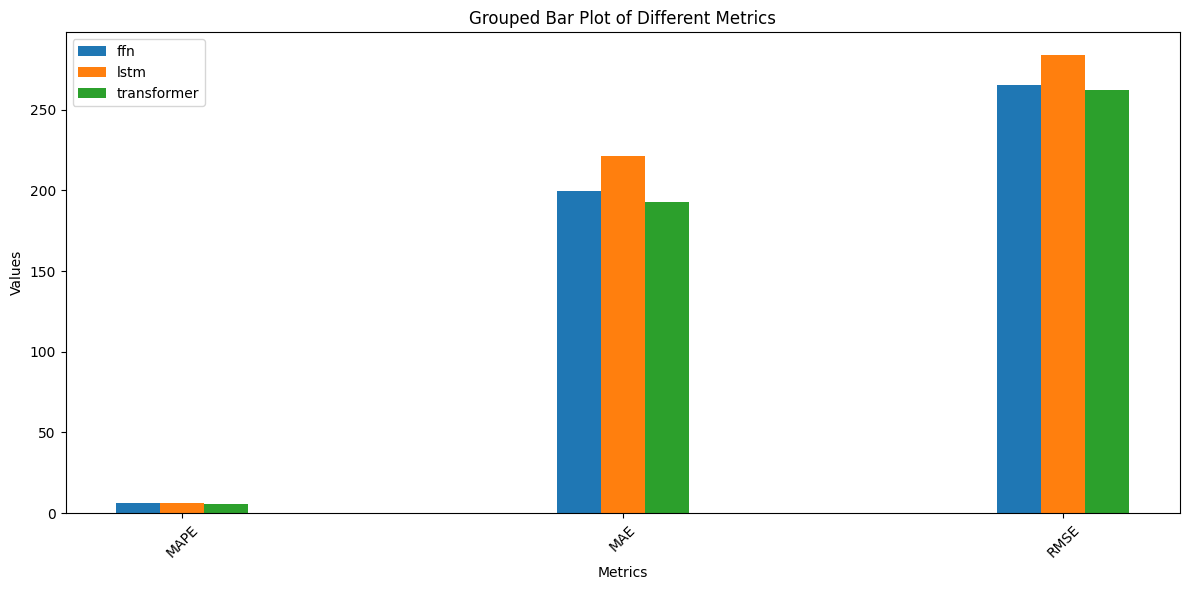

In [49]:
summary_bar_plot(preds=preds, targets=targets)